In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

/data/home/bmi-lab/anaconda3/envs/nayb37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#GPU 사용 가능 여부 확인
USE_CUDA = torch.cuda.is_available()
print('GPU 사용 가능 여부:', USE_CUDA)

GPU 사용 가능 여부: True


In [4]:
#사용할 디바이스 설정 (GPU 또는 CPU)
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('학습을 진행하는 기기:', device)

학습을 진행하는 기기: cuda:0


In [5]:
# CSV 파일 로드
train_data = pd.read_csv('train_55.csv')

# 'Class' 열 숫자 인코딩
label_encoder = LabelEncoder()
train_data['Class'] = label_encoder.fit_transform(train_data['Class'])
class_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print(class_mapping)

# 테스트 데이터 로드
test_data = pd.read_csv('test_149.csv')

# 'Class' 열 숫자 인코딩 (훈련 데이터에서 학습한 label_encoder 사용)
test_data['Class'] = label_encoder.transform(test_data['Class'])

{0: 'de', 1: 'f', 2: 'nor'}


In [6]:
#onehot 파일 폴더 경로
onehot_folder = 'onehot7'
onehot_files = os.listdir(onehot_folder)

# 원핫인코딩 매트릭스를 저장할 딕셔너리
onehot_matrices = {}

# 최대 행 수 찾기
max_rows = 0

# 원핫인코딩 매트릭스 파일들을 로드 (헤더 없음)
for file in onehot_files:
    variant_name = file.split('.csv')[0].replace('_', '.')  # CYP2D6_1.001.csv -> CYP2D6.1.001
    file_path = os.path.join(onehot_folder, file)
    try:
        matrix = pd.read_csv(file_path, header=None).values
        onehot_matrices[variant_name] = matrix
        max_rows = max(max_rows, matrix.shape[0])
        print(f"Loaded {variant_name}: shape {matrix.shape}")
    except Exception as e:
        print(f"Error loading {file}: {str(e)}")

print(f"최대 행 수: {max_rows}")
print(f"로드된 매트릭스 개수: {len(onehot_matrices)}")

Loaded CYP2D6.106.002: shape (4312, 7)
Loaded CYP2D6.35.004: shape (4312, 7)
Loaded CYP2D6.2.004: shape (4312, 7)
Loaded CYP2D6.4.012: shape (4312, 7)
Loaded CYP2D6.36.002: shape (4312, 7)
Loaded CYP2D6.10.003: shape (4312, 7)
Loaded CYP2D6.1.050: shape (4312, 7)
Loaded CYP2D6.105.001: shape (4312, 7)
Loaded CYP2D6.159.001: shape (4312, 7)
Loaded CYP2D6.134.001: shape (4312, 7)
Loaded CYP2D6.155.001: shape (4312, 7)
Loaded CYP2D6.4.015: shape (4312, 7)
Loaded CYP2D6.11.001: shape (4312, 7)
Loaded CYP2D6.71.001: shape (4312, 7)
Loaded CYP2D6.4.003: shape (4312, 7)
Loaded CYP2D6.47.001: shape (4312, 7)
Loaded CYP2D6.4.010: shape (4312, 7)
Loaded CYP2D6.4.024: shape (4312, 7)
Loaded CYP2D6.2.015: shape (4312, 7)
Loaded CYP2D6.164.001: shape (4312, 7)
Loaded CYP2D6.85.001: shape (4312, 7)
Loaded CYP2D6.3.002: shape (4312, 7)
Loaded CYP2D6.1.035: shape (4312, 7)
Loaded CYP2D6.3.003: shape (4312, 7)
Loaded CYP2D6.97.001: shape (4312, 7)
Loaded CYP2D6.1.013: shape (4312, 7)
Loaded CYP2D6.4.00

Loaded CYP2D6.2.008: shape (4312, 7)
Loaded CYP2D6.146.002: shape (4312, 7)
Loaded CYP2D6.109.001: shape (4312, 7)
Loaded CYP2D6.171.001: shape (4313, 7)
Loaded CYP2D6.2.001: shape (4312, 7)
Loaded CYP2D6.15.002: shape (4313, 7)
Loaded CYP2D6.71.003: shape (4312, 7)
Loaded CYP2D6.41.005: shape (4312, 7)
Loaded CYP2D6.35.001: shape (4312, 7)
Loaded CYP2D6.167.001: shape (4312, 7)
Loaded CYP2D6.101.001: shape (4312, 7)
Loaded CYP2D6.168.001: shape (4312, 7)
Loaded CYP2D6.120.001: shape (4312, 7)
Loaded CYP2D6.41.004: shape (4312, 7)
Loaded CYP2D6.1.017: shape (4312, 7)
Loaded CYP2D6.56.003: shape (4312, 7)
Loaded CYP2D6.42.001: shape (4314, 7)
Loaded CYP2D6.4.028: shape (4312, 7)
Loaded CYP2D6.75.002: shape (4312, 7)
Loaded CYP2D6.9.001: shape (4312, 7)
Loaded CYP2D6.128.001: shape (4312, 7)
Loaded CYP2D6.2.016: shape (4312, 7)
Loaded CYP2D6.32.001: shape (4312, 7)
Loaded CYP2D6.1.060: shape (4312, 7)
Loaded CYP2D6.4.023: shape (4312, 7)
Loaded CYP2D6.10.008: shape (4312, 7)
Loaded CYP2D

In [7]:
# 매트릭스 패딩 함수_원래 input으로 들어갈 X가 numpy 배열이었는데 이를 pytorch 텐서로 전환
def pad_matrix(matrix, target_rows=4330, target_cols=7):
    current_rows, current_cols = matrix.shape
    padded = torch.zeros((target_rows, target_cols))
    padded[:current_rows, :current_cols] = torch.tensor(matrix)
    return padded

# 패딩된 매트릭스로 업데이트
for key in onehot_matrices:
    onehot_matrices[key] = pad_matrix(onehot_matrices[key])


# 'Variant' 컬럼의 값을 기반으로 원핫인코딩 매트릭스 매핑
def map_variant_to_onehot(variant):
    variants = variant.split('; ')
    matrices = []
    for v in variants:
        if v in onehot_matrices:
            matrices.append(onehot_matrices[v])
        else:
            print(f"Warning: Matrix not found for variant {v}")
            matrices.append(torch.zeros((4330, 7)))
    
    # 변이가 2개 미만인 경우 0으로 채우기
    while len(matrices) < 2:
        matrices.append(torch.zeros((4330, 7)))
    
    # 첫 두 개의 매트릭스를 행 방향으로 이어붙임
    combined_matrix = torch.vstack(matrices[:2])
    
    return combined_matrix

# 데이터셋마다 매핑된 매트릭스를 생성하는 함수
def map_variants_to_tensor(data):
    mapped_matrices = []
    for variant in data['Variant']:
        mapped_matrix = map_variant_to_onehot(variant)
        mapped_matrices.append(mapped_matrix)
    
    # 매핑된 매트릭스를 PyTorch 텐서로 변환
    X = torch.stack(mapped_matrices)
    y = torch.tensor(data['Class'].values)
    return X, y

# train_data에 대해 매핑된 매트릭스를 텐서로 변환
train_X, train_y = map_variants_to_tensor(train_data)
print("Train X shape:", train_X.shape)
print("Train y shape:", train_y.shape)

# test_data에 대해 매핑된 매트릭스를 텐서로 변환
test_X, test_y = map_variants_to_tensor(test_data)
print("Test X shape:", test_X.shape)
print("Test y shape:", test_y.shape)

Train X shape: torch.Size([2816, 8660, 7])
Train y shape: torch.Size([2816])
Test X shape: torch.Size([149, 8660, 7])
Test y shape: torch.Size([149])


In [8]:
# CNN 및 GCN 데이터 준비
cnn_data = train_X  # CNN 입력 데이터
cnn_data = cnn_data.unsqueeze(1)  # (batch_size, channels, height, width)로 변환
smiles_data = train_data['isomeric'].values  # SMILES 데이터
labels = train_y  # 라벨 데이터

In [9]:
# 데이터 로드 및 전처리
class MultimodalDataset(Dataset):
    def __init__(self, cnn_data, smiles_data, labels):
        self.cnn_data = cnn_data
        self.smiles_data = smiles_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        cnn_input = self.cnn_data[idx]
        smiles = self.smiles_data[idx]
        label = self.labels[idx]
        
        # SMILES를 그래프로 변환
        gcn_data = smiles_to_graph(smiles)
        
        return cnn_input, gcn_data, label

In [10]:
# 데이터셋 생성
dataset = MultimodalDataset(cnn_data, smiles_data, labels)
batch_size=32

In [11]:
# 데이터 로더 생성
def collate_fn(batch):
    cnn_inputs, gcn_data, labels = zip(*batch)
    cnn_inputs = torch.stack(cnn_inputs)
    gcn_batch = Batch.from_data_list(gcn_data)
    labels = torch.stack(labels)
    return cnn_inputs, gcn_batch, labels

In [12]:
print(len(labels))

2816


In [13]:
# CNN 및 GCN 데이터 준비
test_cnn_data = test_X  # CNN 입력 데이터 (테스트용)
test_cnn_data = test_cnn_data.unsqueeze(1)
test_smiles_data = test_data['isomeric'].values  # SMILES 데이터
test_labels = test_y  # 라벨 데이터

In [14]:
# 테스트 데이터셋 생성
test_dataset = MultimodalDataset(test_cnn_data, test_smiles_data, test_labels)

# 테스트 데이터 로더 생성
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(20, 7), stride=(1, 1))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 1))  
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(20, 1), stride=(1, 1))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 1))

        # Fully Connected Layer에서 최종 벡터 크기를 128로 맞춤
        self.fc1 = nn.Linear(34400, 512)  # 2150 차원으로 수정
        self.fc2 = nn.Linear(512, 128)  # 2150 차원으로 수정

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)     
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # Flattening
        x = self.fc1(x)  # 512 크기의 벡터를 생성
        x = nn.ReLU()(x)
        x = self.fc2(x)  # 128 크기의 벡터를 생성
        x = nn.ReLU()(x)
        return x 

In [16]:
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataLoader as GeometricDataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Batch
from rdkit import Chem
from rdkit.Chem import AllChem

In [17]:
# One-hot encoding 함수를 정의
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return [int(x == s) for s in allowable_set]

# 원자 특징을 one-hot 인코딩하는 함수
def atom_to_onehot_features(atom):
    symbol_one_hot = one_of_k_encoding(
        atom.GetSymbol(), 
        ['H', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I', 'other'])  # 원자 기호를 one-hot으로 인코딩
    
    degree_one_hot = one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5])  # 결합수
    explicit_valence_one_hot = one_of_k_encoding(atom.GetExplicitValence(), [0, 1, 2, 3, 4, 5, 6])  # 명시적 원자가
    implicit_valence_one_hot = one_of_k_encoding(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5])  # 암묵적 원자가
    formal_charge_one_hot = one_of_k_encoding(atom.GetFormalCharge(), [-1, 0, 1])  # 형식 전하
    hybridization_one_hot = one_of_k_encoding(atom.GetHybridization(), 
        [Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3, 'other'])  # 혼성화
    aromatic_one_hot = [atom.GetIsAromatic()]  # 방향족성 (True/False)
    # Chiral tag을 one-hot 인코딩으로 추가
    chiral_tag_one_hot = one_of_k_encoding(atom.GetChiralTag(), 
        [Chem.rdchem.ChiralType.CHI_UNSPECIFIED, 
         Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW, 
         Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW, 
         Chem.rdchem.ChiralType.CHI_OTHER])  # 입체화학 정보
    
    # 모든 one-hot 인코딩된 벡터들을 하나로 결합
    return symbol_one_hot + degree_one_hot + explicit_valence_one_hot + implicit_valence_one_hot + formal_charge_one_hot + hybridization_one_hot + aromatic_one_hot + chiral_tag_one_hot

# SMILES to Graph conversion with one-hot encoding for atom features
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(atom_to_onehot_features(atom))  # 각 원자를 one-hot 인코딩
    
    # x는 (N, F) 크기의 텐서, 여기서 N은 원자의 수, F는 특징 벡터의 크기
    x = torch.tensor(atom_features, dtype=torch.float)
    
    # bond 연결 정보를 edge_index로 저장
    rows, cols = [], []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        rows += [start, end]
        cols += [end, start]
    
    edge_index = torch.tensor([rows, cols], dtype=torch.long)
    
    return Data(x=x, edge_index=edge_index)


In [18]:
class GCNModel(nn.Module):
    def __init__(self, num_node_features, hidden_channels):  #, dropout_rate=0.5):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        
        # BatchNorm layers
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.bn3 = nn.BatchNorm1d(hidden_channels)

        # Dropout layer
        #self.dropout = nn.Dropout(0.5)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_channels, 128)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        #x = self.dropout(x)  
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        #x = self.dropout(x)  
        
        x = self.conv3(x, edge_index)
        x = self.bn3(x)

        x = global_mean_pool(x, data.batch)

        x = self.fc(x)
        x = F.relu(x)
        
        return x

In [19]:
class MultimodalModel(nn.Module):
    def __init__(self, cnn_model, gcn_model, cnn_output_dim, gcn_output_dim, num_classes):
        super(MultimodalModel, self).__init__()
        self.cnn_model = cnn_model
        self.gcn_model = gcn_model

        # CNN과 GCN 벡터를 합친 후 사용할 Fully Connected Layer
        self.fc1 = nn.Linear(cnn_output_dim + gcn_output_dim, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, cnn_input, gcn_data):
        # CNN에서 128차원 벡터 추출
        cnn_output = self.cnn_model(cnn_input)

        # GCN에서 128차원 벡터 추출
        gcn_output = self.gcn_model(gcn_data)

        # CNN과 GCN 벡터를 결합
        combined = torch.cat([cnn_output, gcn_output], dim=1)

        # Fully Connected Layer
        x = self.fc1(combined)
        x = F.relu(x)
        x = self.fc2(x)
        return x

### AUPR추가, 표준편차 추가

In [ ]:
# Stratified K-Fold 설정
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 초기화 변수
fold_results = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_auc': [], 
                 'val_aupr': [], 'precision': [], 'recall': [], 'f1': []}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# One-vs-Rest 방식으로 AUPR 계산 함수 정의
def compute_weighted_aupr(y_true, y_probs, num_classes=3):
    auprs = []
    for i in range(num_classes):
        # 각 클래스를 이진 타겟으로 변환 (OvR 방식)
        y_true_binary = (y_true == i).astype(int)
        aupr = average_precision_score(y_true_binary, y_probs[:, i])
        auprs.append(aupr)
    return np.mean(auprs)

# StratifiedKFold로 train/validation 나눠서 학습
for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, train_y)):
    print(f'Fold {fold+1}/{n_splits}')
    
    # Subset으로 train/validation 데이터셋을 나눔
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # 모델 초기화
    cnn_model = SimpleCNN().to(device)
    gcn_model = GCNModel(num_node_features=42, hidden_channels=64).to(device) 
    multimodal_model = MultimodalModel(cnn_model, gcn_model, cnn_output_dim=128, gcn_output_dim=128, num_classes=3)
    multimodal_model.to(device)

    # CNN과 GCN 각각에 대해 다른 학습률을 설정
    cnn_lr = 0.001  # CNN의 학습률
    gcn_lr = 0.001  # GCN의 학습률

    # 각 학습률로 다른 optimizer 설정
    optimizer = torch.optim.Adam([
        {'params': cnn_model.parameters(), 'lr': cnn_lr},
        {'params': gcn_model.parameters(), 'lr': gcn_lr}
    ])
    criterion = torch.nn.CrossEntropyLoss().to(device)
    
    best_val_auc = 0
    patience_counter = 0
    patience = 3

    num_epochs = 30
    for epoch in range(num_epochs):
        multimodal_model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for cnn_inputs, gcn_batch, labels in train_loader:
            cnn_inputs, gcn_batch, labels = cnn_inputs.to(device), gcn_batch.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = multimodal_model(cnn_inputs, gcn_batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        train_acc = 100. * correct_train / total_train
        train_loss = total_train_loss / len(train_loader)

        # Validation
        multimodal_model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_labels, all_preds = [], []

        with torch.no_grad():
            for cnn_inputs, gcn_batch, labels in val_loader:
                cnn_inputs, gcn_batch, labels = cnn_inputs.to(device), gcn_batch.to(device), labels.to(device)

                outputs = multimodal_model(cnn_inputs, gcn_batch)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

                all_labels.append(labels.cpu())
                all_preds.append(outputs.cpu())

        val_acc = 100. * correct_val / total_val
        val_loss /= len(val_loader)

        # Concatenate all labels and predictions
        all_labels = torch.cat(all_labels)
        all_preds = torch.cat(all_preds)

        # Validation ROC-AUC & AUPR 계산
        val_auc = roc_auc_score(all_labels.numpy(), F.softmax(all_preds, dim=1).numpy(), multi_class='ovr')
        val_aupr = compute_weighted_aupr(all_labels.numpy(), F.softmax(all_preds, dim=1).numpy())

        # Precision, Recall, F1 Score 계산
        predicted_labels = all_preds.argmax(dim=1).numpy()
        precision = precision_score(all_labels.numpy(), predicted_labels, average='weighted')
        recall = recall_score(all_labels.numpy(), predicted_labels, average='weighted')
        f1 = f1_score(all_labels.numpy(), predicted_labels, average='weighted')

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val AUC: {val_auc:.4f}, '
              f'Val AUPR: {val_aupr:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

        # Early stopping 체크
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            patience_counter = 0
            torch.save(multimodal_model.state_dict(), f'best_model_fold_{fold}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping 적용.")
                break
    
    # Fold 결과 저장
    fold_results['train_loss'].append(train_loss)
    fold_results['train_acc'].append(train_acc)
    fold_results['val_loss'].append(val_loss)
    fold_results['val_acc'].append(val_acc)
    fold_results['val_auc'].append(val_auc)
    fold_results['val_aupr'].append(val_aupr)
    fold_results['precision'].append(precision)
    fold_results['recall'].append(recall)
    fold_results['f1'].append(f1)

# 평균과 표준편차 계산 함수
def mean_std(values):
    return np.mean(values), np.std(values)

# 각 지표의 평균과 표준편차 계산
metrics = {key: mean_std(values) for key, values in fold_results.items()}

# 결과 출력
print('\nCross-Validation Results:')
for metric, (mean, std) in metrics.items():
    print(f'Mean {metric.capitalize()}: {mean:.4f} ± {std:.4f}')

Fold 1/10


/data/home/bmi-lab/anaconda3/envs/nayb37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/30], Train Loss: 1.0395, Train Acc: 45.11%, Val Loss: 0.9757, Val Acc: 40.78%, Val AUC: 0.7446, Val AUPR: 0.5936, Precision: 0.3081, Recall: 0.4078, F1 Score: 0.3174
Epoch [2/30], Train Loss: 0.7920, Train Acc: 62.94%, Val Loss: 0.5974, Val Acc: 74.11%, Val AUC: 0.9121, Val AUPR: 0.8362, Precision: 0.7753, Recall: 0.7411, F1 Score: 0.7389
Epoch [3/30], Train Loss: 0.5196, Train Acc: 77.70%, Val Loss: 0.4155, Val Acc: 82.27%, Val AUC: 0.9494, Val AUPR: 0.9055, Precision: 0.8496, Recall: 0.8227, F1 Score: 0.8210
Epoch [4/30], Train Loss: 0.3576, Train Acc: 85.75%, Val Loss: 0.3097, Val Acc: 87.59%, Val AUC: 0.9658, Val AUPR: 0.9395, Precision: 0.8760, Recall: 0.8759, F1 Score: 0.8759
Epoch [5/30], Train Loss: 0.3358, Train Acc: 86.58%, Val Loss: 0.2953, Val Acc: 87.59%, Val AUC: 0.9710, Val AUPR: 0.9499, Precision: 0.8836, Recall: 0.8759, F1 Score: 0.8751
Epoch [6/30], Train Loss: 0.2640, Train Acc: 90.29%, Val Loss: 0.2902, Val Acc: 88.30%, Val AUC: 0.9727, Val AUPR: 0.9535, Pr

Epoch [9/30], Train Loss: 0.1625, Train Acc: 93.12%, Val Loss: 0.2637, Val Acc: 85.55%, Val AUC: 0.9806, Val AUPR: 0.9653, Precision: 0.8776, Recall: 0.8555, F1 Score: 0.8543
Epoch [10/30], Train Loss: 0.1523, Train Acc: 94.15%, Val Loss: 0.1902, Val Acc: 90.08%, Val AUC: 0.9854, Val AUPR: 0.9739, Precision: 0.9036, Recall: 0.9008, F1 Score: 0.9010
Epoch [11/30], Train Loss: 0.1296, Train Acc: 95.13%, Val Loss: 0.1606, Val Acc: 92.92%, Val AUC: 0.9902, Val AUPR: 0.9812, Precision: 0.9306, Recall: 0.9292, F1 Score: 0.9291
Epoch [12/30], Train Loss: 0.1257, Train Acc: 95.10%, Val Loss: 0.1414, Val Acc: 93.77%, Val AUC: 0.9918, Val AUPR: 0.9854, Precision: 0.9383, Recall: 0.9377, F1 Score: 0.9378
Epoch [13/30], Train Loss: 0.1156, Train Acc: 95.76%, Val Loss: 0.1705, Val Acc: 92.63%, Val AUC: 0.9887, Val AUPR: 0.9792, Precision: 0.9258, Recall: 0.9263, F1 Score: 0.9257
Epoch [14/30], Train Loss: 0.1105, Train Acc: 95.95%, Val Loss: 0.1267, Val Acc: 95.18%, Val AUC: 0.9944, Val AUPR: 0.990

Epoch [22/30], Train Loss: 0.0740, Train Acc: 97.36%, Val Loss: 0.0757, Val Acc: 97.17%, Val AUC: 0.9976, Val AUPR: 0.9956, Precision: 0.9718, Recall: 0.9717, F1 Score: 0.9716
Epoch [23/30], Train Loss: 0.0645, Train Acc: 97.52%, Val Loss: 0.1071, Val Acc: 93.77%, Val AUC: 0.9958, Val AUPR: 0.9924, Precision: 0.9384, Recall: 0.9377, F1 Score: 0.9378
Epoch [24/30], Train Loss: 0.0625, Train Acc: 97.71%, Val Loss: 0.0935, Val Acc: 96.03%, Val AUC: 0.9959, Val AUPR: 0.9926, Precision: 0.9604, Recall: 0.9603, F1 Score: 0.9602
Epoch [25/30], Train Loss: 0.0504, Train Acc: 98.21%, Val Loss: 0.0911, Val Acc: 95.75%, Val AUC: 0.9967, Val AUPR: 0.9941, Precision: 0.9577, Recall: 0.9575, F1 Score: 0.9574
Early stopping 적용.

Cross-Validation Results:
Mean Train_loss: 0.0836 ± 0.0239
Mean Train_acc: 96.8191 ± 1.1132
Mean Val_loss: 0.1564 ± 0.0472
Mean Val_acc: 93.9179 ± 1.1896
Mean Val_auc: 0.9925 ± 0.0035
Mean Val_aupr: 0.9867 ± 0.0063
Mean Precision: 0.9413 ± 0.0101
Mean Recall: 0.9392 ± 0.0119


### 표준편차 test & 시각화

In [20]:
import torch.nn.functional as F
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ========================
# fold별 성능을 저장할 리스트
# ========================
test_losses = []
accuracies = []
aucs = []
auprs = []
precisions = []
recalls = []
f1_scores = []

# (추가) 클래스별 지표를 fold별로 모아 평균낼 버킷
num_classes = 3  # 필요시 수정
per_class_accuracy_folds = [[] for _ in range(num_classes)]  # one-vs-rest accuracy
per_class_precision_folds = [[] for _ in range(num_classes)]
per_class_recall_folds = [[] for _ in range(num_classes)]
per_class_f1_folds = [[] for _ in range(num_classes)]
per_class_auc_folds       = [[] for _ in range(num_classes)]  # (추가) per-class ROC-AUC
per_class_aupr_folds      = [[] for _ in range(num_classes)]  # (추가) per-class AUPR

# ROC/PR 커브용 저장 (그대로 유지)
all_test_labels_list = []
all_test_preds_list = []

# ============================================
# (수정) One-vs-Rest 방식으로 AUPR 계산 함수
# ============================================
def compute_weighted_aupr(y_true_tensor, y_probs_np, num_classes=3):
    """
    y_true_tensor: torch.Tensor (shape [N], int)
    y_probs_np   : np.ndarray (shape [N, C]), softmax 확률
    return       : 클래수별 AUPR의 단순 평균 (macro)
    """
    if isinstance(y_true_tensor, torch.Tensor):
        y_true_np = y_true_tensor.detach().cpu().numpy()
    else:
        y_true_np = np.asarray(y_true_tensor)

    class_auprs = []
    for i in range(num_classes):
        y_true_binary = (y_true_np == i).astype(int)
        # positive가 하나도 없으면 AP가 정의 안될 수 있으니 예외 처리
        if y_true_binary.sum() == 0:
            # 샘플이 없을 때는 NaN 대신 0.0 또는 np.nan 선택 가능
            class_auprs.append(0.0)
        else:
            class_auprs.append(average_precision_score(y_true_binary, y_probs_np[:, i]))
    return float(np.mean(class_auprs))

# ============================================
# (추가) per-class ROC-AUC / AUPR 계산
# ============================================
def compute_per_class_auc(y_true_np, y_probs_np, num_classes=3):
    aucs = []
    for i in range(num_classes):
        y_true_binary = (y_true_np == i).astype(int)
        pos, neg = y_true_binary.sum(), (y_true_binary == 0).sum()
        if pos == 0 or neg == 0:
            aucs.append(np.nan)  # ROC AUC 정의 불가
        else:
            aucs.append(roc_auc_score(y_true_binary, y_probs_np[:, i]))
    return aucs  # 길이 C

def compute_per_class_aupr(y_true_np, y_probs_np, num_classes=3):
    auprs = []
    for i in range(num_classes):
        y_true_binary = (y_true_np == i).astype(int)
        if y_true_binary.sum() == 0:
            auprs.append(np.nan)  # AP 정의 불가
        else:
            auprs.append(average_precision_score(y_true_binary, y_probs_np[:, i]))
    return auprs  # 길이 C
    
# ============================================
# (추가) 클래스별 accuracy(one-vs-rest) 계산 함수
# ============================================
def per_class_ovr_accuracy(y_true_np, y_pred_np, num_classes=3):
    """
    one-vs-rest accuracy = (TP + TN) / (TP + TN + FP + FN) for each class
    반환: 길이 C의 리스트
    """
    cm = confusion_matrix(y_true_np, y_pred_np, labels=list(range(num_classes)))
    N = cm.sum()
    accs = []
    for c in range(num_classes):
        TP = cm[c, c]
        FN = cm[c, :].sum() - TP
        FP = cm[:, c].sum() - TP
        TN = N - (TP + FP + FN)
        accs.append((TP + TN) / N if N > 0 else 0.0)
    return accs

# =========================
# 10개의 fold에 대해 평가
# =========================
for fold in range(10):
    print(f'\nEvaluating fold {fold + 1}...')
    
    multimodal_model.load_state_dict(torch.load(f'best_model_fold_{fold}.pth', map_location=device))
    multimodal_model.to(device)
    multimodal_model.eval()
    
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_test_labels = []
    all_test_logits = []

    with torch.no_grad():
        for cnn_inputs, gcn_batch, labels in test_loader:
            cnn_inputs = cnn_inputs.to(device)
            gcn_batch = gcn_batch.to(device)
            labels = labels.to(device)

            outputs = multimodal_model(cnn_inputs, gcn_batch)  # logits, shape [B, C]
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(dim=1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

            all_test_labels.append(labels.detach().cpu())
            all_test_logits.append(outputs.detach().cpu())

    # fold별 예측/라벨 집계
    all_test_labels = torch.cat(all_test_labels)                 # [N]
    all_test_logits = torch.cat(all_test_logits)                 # [N, C]
    all_test_probs = F.softmax(all_test_logits, dim=1).cpu().numpy()
    y_true_np = all_test_labels.cpu().numpy()
    y_pred_np = all_test_logits.argmax(dim=1).cpu().numpy()

    # 저장 (ROC/PR 곡선용)
    all_test_labels_list.append(y_true_np)
    all_test_preds_list.append(all_test_probs)

    # ===== Fold-level 전체 지표 =====
    test_auc = roc_auc_score(y_true_np, all_test_probs, multi_class='ovr')
    test_aupr = compute_weighted_aupr(all_test_labels, all_test_probs, num_classes=num_classes)

    precision_w = precision_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
    recall_w    = recall_score(y_true_np, y_pred_np, average='weighted', zero_division=0)
    f1_w        = f1_score(y_true_np, y_pred_np, average='weighted', zero_division=0)

    accuracy = 100.0 * correct_test / total_test

    test_losses.append(test_loss / len(test_loader))
    accuracies.append(accuracy)
    aucs.append(test_auc)
    auprs.append(test_aupr)
    precisions.append(precision_w)
    recalls.append(recall_w)
    f1_scores.append(f1_w)

    # ===== Fold-level 클래스별 지표 =====
    # classification_report에서 per-class precision/recall/f1 얻기
    report = classification_report(
        y_true_np, y_pred_np, labels=list(range(num_classes)),
        output_dict=True, zero_division=0
    )
    # one-vs-rest accuracy
    per_cls_acc = per_class_ovr_accuracy(y_true_np, y_pred_np, num_classes=num_classes)
    per_cls_auc  = compute_per_class_auc (y_true_np, all_test_probs, num_classes=num_classes)
    per_cls_aupr = compute_per_class_aupr(y_true_np, all_test_probs, num_classes=num_classes)

    # 버킷에 저장(나중에 fold 평균)
    for c in range(num_classes):
        per_class_accuracy_folds[c].append(per_cls_acc[c])
        per_class_precision_folds[c].append(report[str(c)]['precision'])
        per_class_recall_folds[c].append(report[str(c)]['recall'])
        per_class_f1_folds[c].append(report[str(c)]['f1-score'])
        per_class_auc_folds[c].append(per_cls_auc[c])
        per_class_aupr_folds[c].append(per_cls_aupr[c])

    # (옵션) fold별 클래스별 출력
    print(f'Fold {fold+1} per-class metrics:')
    for c in range(num_classes):
        p = report[str(c)]['precision']; r = report[str(c)]['recall']; f1 = report[str(c)]['f1-score']
        auc_c  = per_cls_auc[c]
        aupr_c = per_cls_aupr[c]
        auc_str  = f'{auc_c:.4f}'  if not np.isnan(auc_c)  else 'NA'
        aupr_str = f'{aupr_c:.4f}' if not np.isnan(aupr_c) else 'NA'
        print(f'  Class {c} | Acc(ovr): {per_cls_acc[c]:.4f}  '
              f'Prec: {p:.4f}  Rec: {r:.4f}  F1: {f1:.4f}  '
              f'AUC: {auc_str}  AUPR: {aupr_str}')

# ============================
# 평균과 표준편차 계산 유틸
# ============================
def mean_and_std(values):
    return float(np.mean(values)), float(np.std(values))

def nanmean_and_nanstd(values):
    return float(np.nanmean(values)), float(np.nanstd(values))

mean_test_loss, std_test_loss = mean_and_std(test_losses)
mean_accuracy, std_accuracy   = mean_and_std(accuracies)
mean_auc, std_auc             = mean_and_std(aucs)
mean_aupr, std_aupr           = mean_and_std(auprs)
mean_precision, std_precision = mean_and_std(precisions)
mean_recall, std_recall       = mean_and_std(recalls)
mean_f1, std_f1               = mean_and_std(f1_scores)

print('\n=== Overall (10-fold) metrics ===')
print(f'Mean Test Loss: {mean_test_loss:.4f} ± {std_test_loss:.4f}, '
      f'Mean Test Accuracy: {mean_accuracy:.2f}% ± {std_accuracy:.2f}%, '
      f'Mean Test AUC: {mean_auc:.4f} ± {std_auc:.4f}, '
      f'Mean Test AUPR: {mean_aupr:.4f} ± {std_aupr:.4f}, '
      f'Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}, '
      f'Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}, '
      f'Mean F1 Score: {mean_f1:.4f} ± {std_f1:.4f}')

# ============================
# (추가) 클래스별 평균±표준편차
# ============================
print('\n=== Per-class metrics averaged over 10 folds ===')
for c in range(num_classes):
    acc_mu, acc_sd = mean_and_std(per_class_accuracy_folds[c])
    pr_mu,  pr_sd  = mean_and_std(per_class_precision_folds[c])
    rc_mu,  rc_sd  = mean_and_std(per_class_recall_folds[c])
    f1_mu,  f1_sd  = mean_and_std(per_class_f1_folds[c])
    auc_mu,  auc_sd  = nanmean_and_nanstd(per_class_auc_folds[c])   # NaN 무시
    aupr_mu, aupr_sd = nanmean_and_nanstd(per_class_aupr_folds[c])  # NaN 무시

    print(f'Class {c}: '
          f'Acc(ovr) {acc_mu:.4f} ± {acc_sd:.4f}, '
          f'Prec {pr_mu:.4f} ± {pr_sd:.4f}, '
          f'Rec {rc_mu:.4f} ± {rc_sd:.4f}, '
          f'F1 {f1_mu:.4f} ± {f1_sd:.4f}, '
          f'AUC {auc_mu:.4f} ± {auc_sd:.4f}, '
          f'AUPR {aupr_mu:.4f} ± {aupr_sd:.4f}')



Evaluating fold 1...
Fold 1 per-class metrics:
  Class 0 | Acc(ovr): 0.8523  Prec: 0.8478  Rec: 0.7222  F1: 0.7800  AUC: 0.9119  AUPR: 0.8782
  Class 1 | Acc(ovr): 0.9195  Prec: 0.8393  Rec: 0.9400  F1: 0.8868  AUC: 0.9667  AUPR: 0.9556
  Class 2 | Acc(ovr): 0.9195  Prec: 0.8511  Rec: 0.8889  F1: 0.8696  AUC: 0.9637  AUPR: 0.8869

Evaluating fold 2...
Fold 2 per-class metrics:
  Class 0 | Acc(ovr): 0.8389  Prec: 0.9167  Rec: 0.6111  F1: 0.7333  AUC: 0.9021  AUPR: 0.8669
  Class 1 | Acc(ovr): 0.9262  Prec: 0.8421  Rec: 0.9600  F1: 0.8972  AUC: 0.9776  AUPR: 0.9631
  Class 2 | Acc(ovr): 0.8993  Prec: 0.7679  Rec: 0.9556  F1: 0.8515  AUC: 0.9598  AUPR: 0.8682

Evaluating fold 3...
Fold 3 per-class metrics:
  Class 0 | Acc(ovr): 0.8322  Prec: 0.7636  Rec: 0.7778  F1: 0.7706  AUC: 0.8957  AUPR: 0.8561
  Class 1 | Acc(ovr): 0.9128  Prec: 0.8936  Rec: 0.8400  F1: 0.8660  AUC: 0.9723  AUPR: 0.9591
  Class 2 | Acc(ovr): 0.9060  Prec: 0.8298  Rec: 0.8667  F1: 0.8478  AUC: 0.9459  AUPR: 0.7979



### 신뢰구간

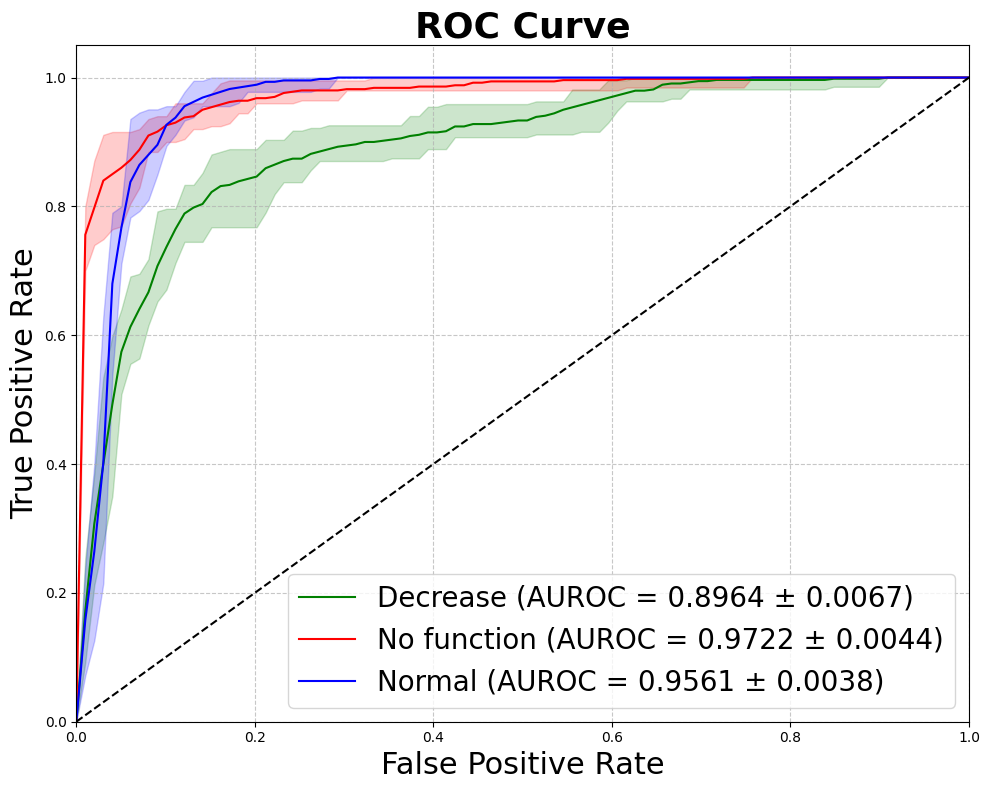

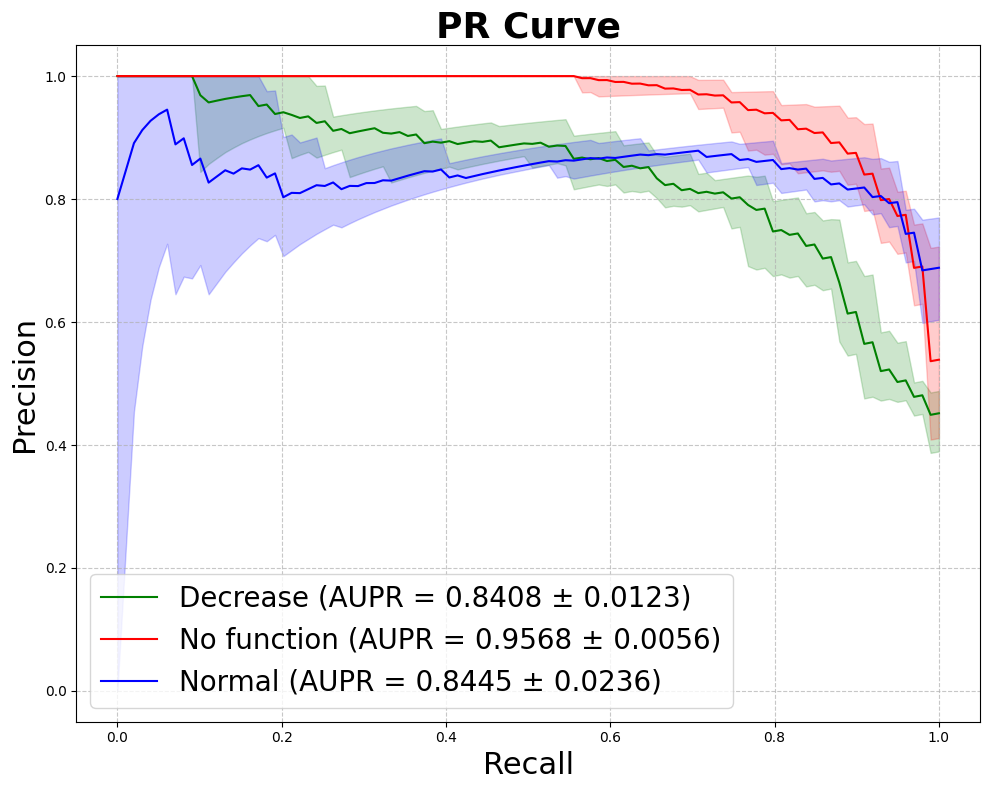

In [21]:
from scipy import stats
def plot_mean_roc_curve(y_true_list, y_probs_list, num_classes=3, font_size=22):
    plt.figure(figsize=(10, 8))
    mean_fpr = np.linspace(0, 1, 100)
    class_labels = ['Decrease', 'No function', 'Normal']
    colors = ['green', 'red', 'blue']
    
    for i in range(num_classes):
        tprs = []
        aucs = []
        for y_true, y_probs in zip(y_true_list, y_probs_list):
            fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            aucs.append(auc(fpr, tpr))
        
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        
        # Calculate 95% confidence interval
        tprs_upper = np.percentile(tprs, 97.5, axis=0)
        tprs_lower = np.percentile(tprs, 2.5, axis=0)
        
        plt.plot(mean_fpr, mean_tpr, color=colors[i], 
                 label=f'{class_labels[i]} (AUROC = {mean_auc:.4f} ± {std_auc:.4f})')
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[i], alpha=0.2)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=font_size)
    plt.ylabel('True Positive Rate', fontsize=font_size)
    plt.title('ROC Curve', fontsize=font_size + 4, fontweight='bold')
    plt.legend(loc='lower right', fontsize=font_size - 2)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_mean_precision_recall_curve(y_true_list, y_probs_list, num_classes=3, font_size=22):
    plt.figure(figsize=(10, 8))
    mean_recall = np.linspace(0, 1, 100)
    class_labels = ['Decrease', 'No function', 'Normal']
    colors = ['green', 'red', 'blue']
    
    for i in range(num_classes):
        precisions = []
        auprs = []
        for y_true, y_probs in zip(y_true_list, y_probs_list):
            precision, recall, _ = precision_recall_curve(y_true == i, y_probs[:, i])
            precisions.append(np.interp(mean_recall, recall[::-1], precision[::-1]))
            auprs.append(np.trapz(precision, recall))
        
        mean_precision = np.mean(precisions, axis=0)
        mean_aupr = np.mean(auprs)
        std_aupr = np.std(auprs)
        
        # Calculate 95% confidence interval
        precisions_upper = np.percentile(precisions, 97.5, axis=0)
        precisions_lower = np.percentile(precisions, 2.5, axis=0)
        
        plt.plot(mean_recall, mean_precision, color=colors[i],
                 label=f'{class_labels[i]} (AUPR = {abs(mean_aupr):.4f} ± {abs(std_aupr):.4f})')
        plt.fill_between(mean_recall, precisions_lower, precisions_upper, color=colors[i], alpha=0.2)

    plt.xlabel('Recall', fontsize=font_size)
    plt.ylabel('Precision', fontsize=font_size)
    plt.title('PR Curve', fontsize=font_size + 4, fontweight='bold')
    plt.legend(loc='lower left', fontsize=font_size - 2)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# ROC 및 PR 커브 시각화
plot_mean_roc_curve(all_test_labels_list, all_test_preds_list, num_classes=3)
plot_mean_precision_recall_curve(all_test_labels_list, all_test_preds_list, num_classes=3)